In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.stats import gaussian_kde
from scipy import signal
import sys
from collections import deque
import pylab as pl
import networkx as nx
sys.setrecursionlimit(1000000)
from PIL import Image

In [4]:
def make_lattice(n):
    lattice = np.random.rand(n, n)
    return lattice

In [5]:
def change_lattice(lattice, p):
    new_lattice = np.where(lattice <= p, 1, 0)
    return new_lattice

In [6]:
def find_max(lst, p):
    '''this function finds the max of a list and shows where the max is located'''
    max_value = lst[0]
    max_index = 0

    for i in range(1, len(lst)):
        if lst[i] > max_value:
            max_value = lst[i]
            max_index = i

    return p[max_index], max_value

In [7]:
def percolate(grid, start_row, start_col, visited):
    rows, cols = grid.shape
    queue = deque([(start_row, start_col)])
    cluster_size = 0

    while queue:
        row, col = queue.popleft()

        if (row, col) in visited or not (0 <= row < rows) or not (0 <= col < cols) or grid[row, col] == 0:
            continue

        visited.add((row, col))
        cluster_size += 1

        neighbors = [(row, col + 1), (row, col - 1), (row + 1, col), (row - 1, col)]
        queue.extend(neighbor for neighbor in neighbors if neighbor not in visited)

    return cluster_size

In [8]:
def find_clusters(grid):
    rows, cols = grid.shape
    visited = set()
    cluster_sizes = []
    largest_cluster = []
    largest_cluster_size = 0

    for row in range(rows):
        for col in range(cols):
            if grid[row, col] == 1 and (row, col) not in visited:
                cluster_size = percolate(grid, row, col, visited)
                cluster_sizes.append(cluster_size)
                if cluster_size > largest_cluster_size:
                    largest_cluster = list(visited)
                    largest_cluster_size = cluster_size



    if len(cluster_sizes) != 0:
        cluster_sizes.remove(largest_cluster_size)
        if len(cluster_sizes) != 0:
            c_s = np.array(cluster_sizes)
            c_s_squared = c_s**2
            mean = sum(c_s) / len(c_s)
            susceptibility = sum(c_s_squared) / len(c_s)
        else:
            mean = 0
            susceptibility = 0
    else:
        mean = 0
        susceptibility = 0

    return mean, susceptibility, largest_cluster, largest_cluster_size

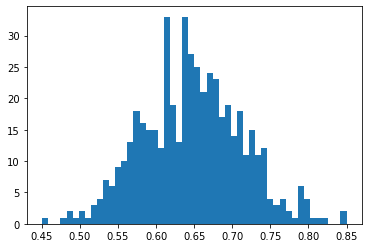

In [9]:
# making a list for p with more values around 0.6, 0.5<p<0.7
# we do this because we know that the critical point is in this interval
# the figure is the histogram of points
lower_limit = 0.45
upper_limit = 0.85
p_list = np.random.normal(loc=0.65, scale=0.07, size=(500))
p_list = np.clip(p_list, lower_limit, upper_limit)
p_list.sort()
plt.hist(p_list, bins=50);

In [9]:
def percolation_with_ensemble(n, k=100):
    '''makes a percolation with ensembles and returns mean cluster sizes and susceptibility'''
    mean_cluster_size = []
    susceptibilities = []
    for p in p_list:
        means = []
        means_squared = []
        for _ in range(k):
            lattice = make_lattice(n)
            new_lattice = change_lattice(lattice, p)
            mean, susceptibility, largest_cluster, largest_cluster_size = find_clusters(new_lattice)
            means.append(mean)
            means_squared.append(susceptibility)
        average_mean = np.mean(means)
        mean_cluster_size.append(average_mean)
        average_mean_squared = np.mean(means_squared)
        susceptibilities.append(average_mean_squared)

    return mean_cluster_size, susceptibilities

In [10]:
def smooth(lst, size=399, std=15):
    '''applies a kernel to a list'''
    kernel = signal.gaussian(size, std)
    kernel = kernel/np.sum(kernel)
    smoothed_lst = np.convolve(lst, kernel, mode='same')
    return smoothed_lst

In [11]:
def make_bool_largest_cluster(n, p):
    lattice = make_lattice(n)
    lattice = change_lattice(lattice, p)
    giant_cluster = find_clusters(lattice)[2]
    largest_cluster_mask = np.zeros_like(lattice, dtype=bool)
    for row, col in giant_cluster:
        largest_cluster_mask[row, col] = True
    return largest_cluster_mask

In [12]:
def box_counting_fractal_dimension(binary_array):
    # Calculate the fractal dimension using the box-counting method
    L = binary_array.shape[0]
    counts = []

    # Iterate over different box sizes
    for box_size in range(1, L // 2 + 1):
        count = 0

        # Iterate over each box with the given size and count the filled boxes
        for i in range(0, L, box_size):
            for j in range(0, L, box_size):
                if np.any(binary_array[i:i+box_size, j:j+box_size]):
                    count += 1

        counts.append(count)

    # Fit a linear regression to the log-log plot of box sizes and counts
    coeffs = np.polyfit(np.log(range(1, L // 2 + 1)), np.log(counts), 1)
    fractal_dimension = -coeffs[0]

    return fractal_dimension

In [15]:
mean_cluster_size16, susceptibility16 = percolation_with_ensemble(16)

In [16]:
mean_cluster_size32, susceptibility32 = percolation_with_ensemble(32)

In [17]:
mean_cluster_size64, susceptibility64 = percolation_with_ensemble(64)

In [18]:
mean_cluster_size128, susceptibility128 = percolation_with_ensemble(128)

In [19]:
mean_cluster_size256, susceptibility256 = percolation_with_ensemble(256)

In [20]:
print(find_max(smooth(susceptibility256), p_list))

(0.5915187033843397, 17904.453471470366)


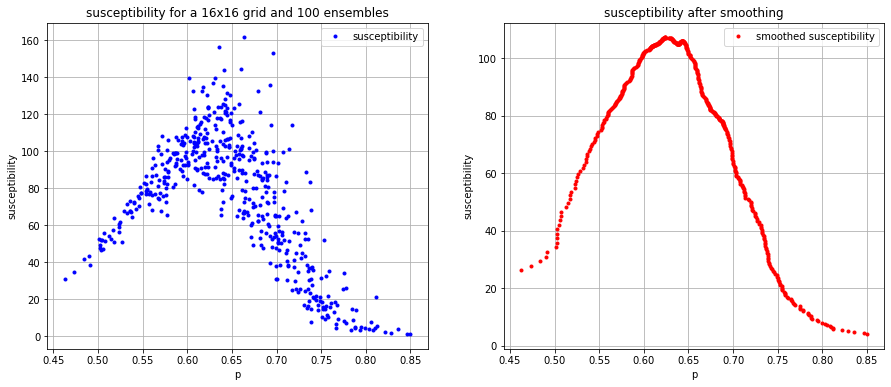

In [21]:
# Create plots for n = 16
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns, and adjust the figure size

# Plot 1
axes[0].plot(p_list, susceptibility16,'.', label='susceptibility', color='blue')
axes[0].set_xlabel('p')
axes[0].set_ylabel('susceptibility')
axes[0].legend()
axes[0].set_title('susceptibility for a 16x16 grid and 100 ensembles')
axes[0].grid(True)

# Plot 2
axes[1].plot(p_list, smooth(susceptibility16, std=15), '.', label='smoothed susceptibility', color='red')
axes[1].set_xlabel('p')
axes[1].set_ylabel('susceptibility')
axes[1].legend()
axes[1].set_title('susceptibility after smoothing')
axes[1].grid(True)

plt.show()

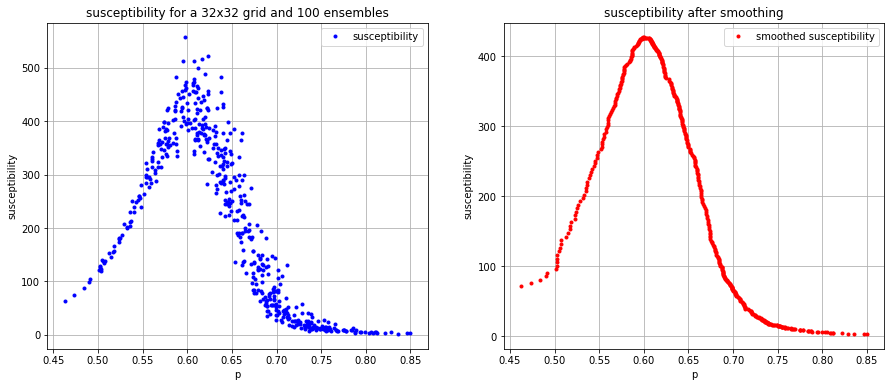

In [22]:
# Create plots for n = 32
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns, and adjust the figure size

# Plot 1
axes[0].plot(p_list, susceptibility32,'.', label='susceptibility', color='blue')
axes[0].set_xlabel('p')
axes[0].set_ylabel('susceptibility')
axes[0].legend()
axes[0].set_title('susceptibility for a 32x32 grid and 100 ensembles')
axes[0].grid(True)

# Plot 2
axes[1].plot(p_list, smooth(susceptibility32, std=15), '.', label='smoothed susceptibility', color='red')
axes[1].set_xlabel('p')
axes[1].set_ylabel('susceptibility')
axes[1].legend()
axes[1].set_title('susceptibility after smoothing')
axes[1].grid(True)

plt.show()

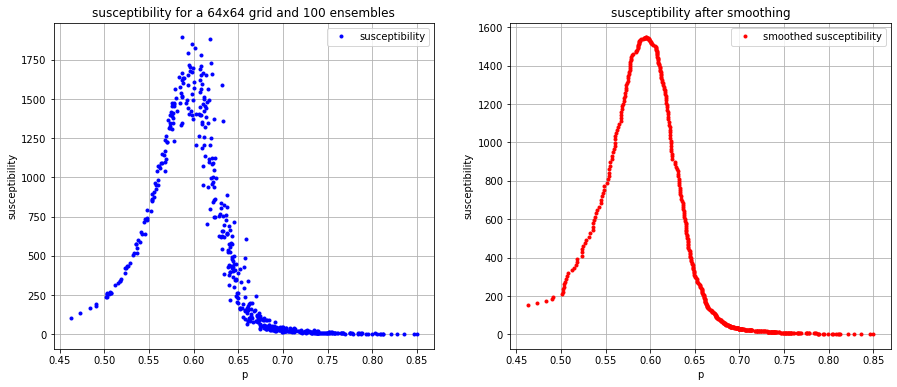

In [23]:
# Create plots for n = 64
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns, and adjust the figure size

# Plot 1
axes[0].plot(p_list, susceptibility64,'.', label='susceptibility', color='blue')
axes[0].set_xlabel('p')
axes[0].set_ylabel('susceptibility')
axes[0].legend()
axes[0].set_title('susceptibility for a 64x64 grid and 100 ensembles')
axes[0].grid(True)

# Plot 2
axes[1].plot(p_list, smooth(susceptibility64, std=15), '.', label='smoothed susceptibility', color='red')
axes[1].set_xlabel('p')
axes[1].set_ylabel('susceptibility')
axes[1].legend()
axes[1].set_title('susceptibility after smoothing')
axes[1].grid(True)

plt.show()

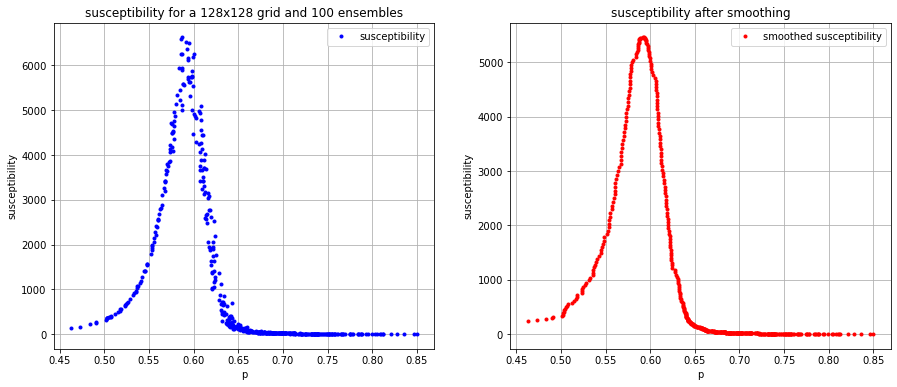

In [24]:
# Create plots for n = 128
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns, and adjust the figure size

# Plot 1
axes[0].plot(p_list, susceptibility128,'.', label='susceptibility', color='blue')
axes[0].set_xlabel('p')
axes[0].set_ylabel('susceptibility')
axes[0].legend()
axes[0].set_title('susceptibility for a 128x128 grid and 100 ensembles')
axes[0].grid(True)

# Plot 2
axes[1].plot(p_list, smooth(susceptibility128, std=15), '.', label='smoothed susceptibility', color='red')
axes[1].set_xlabel('p')
axes[1].set_ylabel('susceptibility')
axes[1].legend()
axes[1].set_title('susceptibility after smoothing')
axes[1].grid(True)

plt.show()

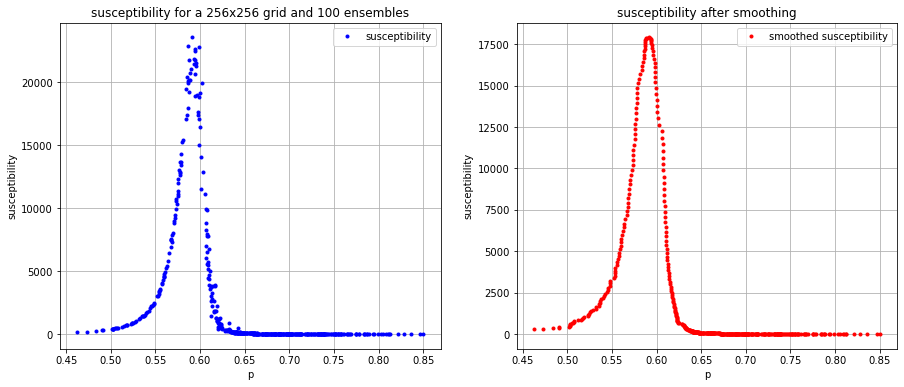

In [25]:
# Create plots for n = 256
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns, and adjust the figure size

# Plot 1
axes[0].plot(p_list, susceptibility256,'.', label='susceptibility', color='blue')
axes[0].set_xlabel('p')
axes[0].set_ylabel('susceptibility')
axes[0].legend()
axes[0].set_title('susceptibility for a 256x256 grid and 100 ensembles')
axes[0].grid(True)

# Plot 2
axes[1].plot(p_list, smooth(susceptibility256, std=15), '.', label='smoothed susceptibility', color='red')
axes[1].set_xlabel('p')
axes[1].set_ylabel('susceptibility')
axes[1].legend()
axes[1].set_title('susceptibility after smoothing')
axes[1].grid(True)

plt.show()

In [26]:
maxes = []
maxes.append(find_max(smooth(susceptibility16), p_list))
maxes.append(find_max(smooth(susceptibility32), p_list))
maxes.append(find_max(smooth(susceptibility64), p_list))
maxes.append(find_max(smooth(susceptibility128), p_list))

In [27]:
maxes

[(0.6239879884000424, 107.20869153567232),
 (0.5994752421866022, 426.8037713430957),
 (0.5949170198585758, 1547.21612109711),
 (0.5915187033843397, 5459.355286857604)]

In [28]:
maxess = np.array([108.42746853237253, 435.7231225528206, 1597.8537002968758, 5636.404254595835])
sizes = np.array([16, 32, 64, 128])

In [29]:
maxesss = np.log(maxess)
sizess = np.log(sizes)

In [30]:
fit = np.polyfit(sizess, maxesss, 1)
m, b = fit[0], fit[1]

In [31]:
x = np.linspace(2.5, 5, 100)
y = m*x + b

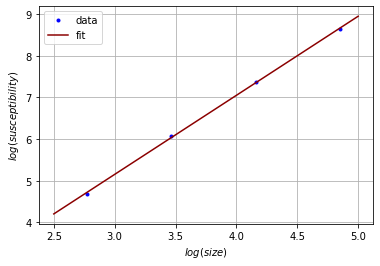

the slope is: 1.8974570424114219


In [32]:
plt.plot(sizess, maxesss, '.', label='data', color='b');
plt.plot(x, y, label='fit', color='darkred');
plt.xlabel('$log(size)$');
plt.ylabel('$log(susceptibility)$');
plt.grid();
plt.legend();
plt.show()
print(f'the slope is: {m}')

#  Calulating the fractal dimension of the largest cluster at critical p

In [33]:
# this list contains the maximum susceptibility of lattice with sizes = {16, 32, 64, 128} and their critical p respectly
maxes = np.array([(0.6235995330773284, 108.42746853237253),
                (0.6083278165362717, 435.7231225528206),
                (0.5944119331452755, 1597.8537002968758),
                (0.5937207508036668, 5636.404254595835),
                (0.5901862786554873, 19112.281174848766)])

### Plotting the largest cluster
Now, we try to find the largest cluster and plot it for sizes of 32, 64, 128 when $p = p_c$.

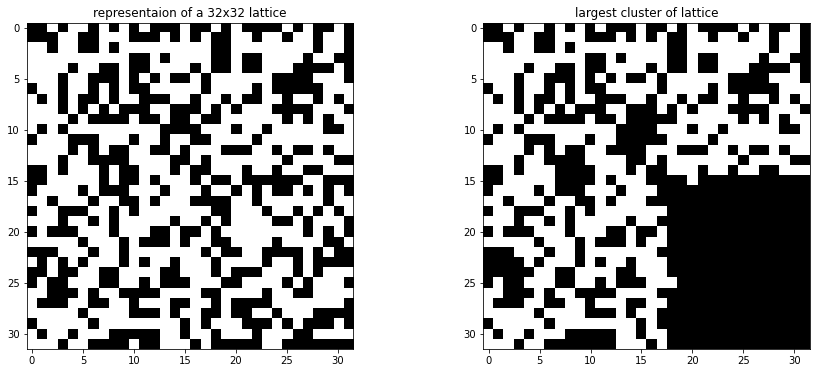

In [34]:
# for a 32x32 lattice and at its critical p
n = 32
p = 0.6084

lattice = make_lattice(n)
lattice = change_lattice(lattice, p)
giant_cluster = find_clusters(lattice)[2]
largest_cluster_mask = np.zeros_like(lattice, dtype=bool)
for row, col in giant_cluster:
    largest_cluster_mask[row, col] = True

fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns, and adjust the figure size

# Plot 1
axes[0].imshow(lattice, cmap='gray')
axes[0].set_title('representaion of a 32x32 lattice')

# Plot 2
axes[1].imshow(largest_cluster_mask, cmap='gray')
axes[1].set_title('largest cluster of lattice')

plt.show()

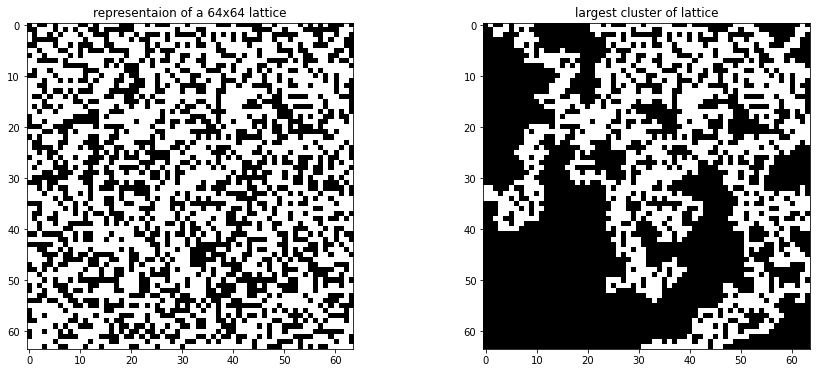

In [35]:
# for a 64x64 lattice and at its critical p
n = 64
p = 0.5945

lattice = make_lattice(n)
lattice = change_lattice(lattice, p)
giant_cluster = find_clusters(lattice)[2]
largest_cluster_mask = np.zeros_like(lattice, dtype=bool)
for row, col in giant_cluster:
    largest_cluster_mask[row, col] = True

fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns, and adjust the figure size

# Plot 1
axes[0].imshow(lattice, cmap='gray')
axes[0].set_title('representaion of a 64x64 lattice')

# Plot 2
axes[1].imshow(largest_cluster_mask, cmap='gray')
axes[1].set_title('largest cluster of lattice')

plt.show()

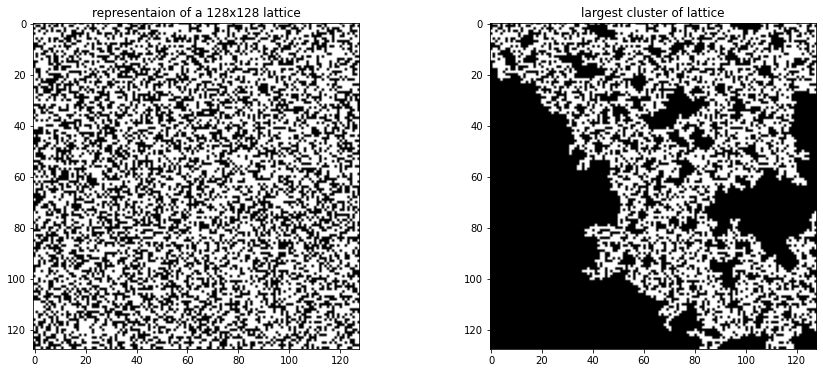

In [36]:
# for a 128x128 lattice and at its critical p
n = 128
p = 0.5938

lattice = make_lattice(n)
lattice = change_lattice(lattice, p)
giant_cluster = find_clusters(lattice)[2]
largest_cluster_mask = np.zeros_like(lattice, dtype=bool)
for row, col in giant_cluster:
    largest_cluster_mask[row, col] = True

fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns, and adjust the figure size

# Plot 1
axes[0].imshow(lattice, cmap='gray')
axes[0].set_title('representaion of a 128x128 lattice')

# Plot 2
axes[1].imshow(largest_cluster_mask, cmap='gray')
axes[1].set_title('largest cluster of lattice')

plt.show()

### claculating the fractal dimension of the largest cluster
Now, we want to calculate the fractal dimension of the giant cluster using box counting method. By the aid of the function ```box_counting_fractal_dimension``` we can achieve our goal. However, this fucntion requires a numpy 2d array with ```dtype = bool``` which we can prepare the entry by utilizing another function called ```make_bool_largest_cluster```.
First we calculate the fractal dimension for sizes = 32, 64, 128 for 100 times and make an overage over the values. Then, we compare the results.

In [37]:
n = 32
p = 0.6084

blc_list = [box_counting_fractal_dimension(make_bool_largest_cluster(n, p)) for _ in range(100)]
print(f'the mean fractal dimension for {n}x{n} lattice at p = {p} is: {np.mean(blc_list)}')

the mean fractal dimension for 32x32 lattice at p = 0.6084 is: 1.6412157250043597


In [38]:
n = 64
p = 0.5945

blc_list = [box_counting_fractal_dimension(make_bool_largest_cluster(n, p)) for _ in range(100)]
print(f'the mean fractal dimension for {n}x{n} lattice at p = {p} is: {np.mean(blc_list)}')

the mean fractal dimension for 64x64 lattice at p = 0.5945 is: 1.6539696011994847


In [39]:
n = 128
p = 0.5938

blc_list = [box_counting_fractal_dimension(make_bool_largest_cluster(n, p)) for _ in range(100)]
print(f'the mean fractal dimension for {n}x{n} lattice at p = {p} is: {np.mean(blc_list)}')

the mean fractal dimension for 128x128 lattice at p = 0.5938 is: 1.7052439675462756


In [40]:
p_l = np.array([0.6235995330773284, 0.6083278165362717, 0.5944119331452755, 0.5937207508036668])
p_l = np.log(p_l)

p_inf = np.ones(4)
p_inf = 19112.281174848766 * p_inf
p_inf = np.log(p_inf)

log_l_inf = p_l - p_inf

In [41]:
log_l = np.array([16, 32, 64, 128])
log_l = np.log(log_l)

In [42]:
fit = np.polyfit(log_l, log_l_inf, 1)
alpha, b = fit[0], fit[1]

In [44]:
print(f'the slope (alpha) is: {alpha}')

the slope (alpha) is: -0.024589182863791487
